In [13]:
import momepy as mm
import numpy as np
import numba
import geopandas as gpd
import pandas as pd
import shapely
from fast_hdbscan.numba_kdtree import NumbaKDTree, kdtree_to_numba, rdist, point_to_node_lower_bound_rdist
from sklearn.preprocessing import StandardScaler
from collections import namedtuple
from core.cluster_validation import get_linkage_matrix
import umap

In [14]:
regions_datadir = "/data/uscuni-ulce/"
morphotopes_dir = '/data/uscuni-ulce/processed_data/morphotopes/'
model_params = '_100_3_None_gaussian'

In [15]:
%%time

### read all morphotopes
region_hulls = gpd.read_parquet(
        regions_datadir + "regions/" + "cadastre_regions_hull.parquet"
)

data = []
for region_id, _ in region_hulls.iterrows():
    region_morphotope_data = pd.read_parquet(f'{morphotopes_dir}data_morphotopes_{region_id}{model_params}.pq')
    region_morphotope_data.index = str(region_id) + '_' + region_morphotope_data.index.str[:]
    data.append(region_morphotope_data)

data = pd.concat(data)

CPU times: user 11 s, sys: 3.22 s, total: 14.3 s
Wall time: 6.7 s


In [16]:
data.shape

(949512, 190)

In [17]:
# ## read a single region
# region_id = 86873
# data = pd.read_parquet(f'{morphotopes_dir}data_morphotopes_{region_id}{model_params}.pq')
# data.index = str(region_id) + '_' + data.index

In [20]:
sizes = data.iloc[:, -1]
data = data.iloc[:, :-1]

In [7]:
vals = StandardScaler().fit_transform(data)
component_data = pd.DataFrame(vals, columns=data.columns, index=data.index)
component_data = component_data.drop(component_data.columns[component_data.std() == 0], axis=1)

# component_data = component_data[component_data.index >= 0]
vals = np.nan_to_num(component_data)
component_data = pd.DataFrame(vals, columns=component_data.columns, index=component_data.index)

In [8]:
sizes.sort_values(ascending=False).iloc[:100]

99886_436_1     75234
44478_0_1       57287
93167_6_1       56198
35368_6_1       54902
123904_94_1     49334
                ...  
16242_3648_1    21211
38248_9_1       21177
22704_4_1       21125
120961_23_0     20888
4_430_0         20790
Name: (Size, Size), Length: 100, dtype: int64

In [9]:
# %%capture cap

# n_neighbors = 25
# umap_metric = 'euclidean'

# reducer = umap.UMAP(n_neighbors=n_neighbors, n_components=20, 
#                     min_dist=0, negative_sample_rate=50, 
#                     metric=umap_metric, verbose=True, random_state=1)

# embedding = reducer.fit_transform(component_data.values)


# ## save the data for later
# import joblib
# filename = f'../data/umap_morphotopes_model_{n_neighbors}.sav'
# joblib.dump(reducer, filename)
# pd.DataFrame(embedding, index=data.index).to_parquet(f'../data/umap_embedding_{n_neighbors}.pq')

In [10]:
# %%capture cap

# n_neighbors = 10
# umap_metric = 'euclidean'

# reducer = umap.UMAP(n_neighbors=n_neighbors, n_components=20, 
#                     min_dist=0, negative_sample_rate=50, 
#                     metric=umap_metric, verbose=True, random_state=1)

# embedding = reducer.fit_transform(component_data.values)

# ## save the data for later
# import joblib
# filename = f'../data/umap_morphotopes_model_{n_neighbors}.sav'
# joblib.dump(reducer, filename)
# pd.DataFrame(embedding, index=data.index).to_parquet(f'../data/umap_embedding_{n_neighbors}.pq')

In [11]:
cap.show()

NameError: name 'cap' is not defined

In [ ]:
# component_data = pd.DataFrame(embedding)

In [18]:
n_neighbors = 25
component_data = pd.read_parquet(f'../data/umap_embedding_{n_neighbors}.pq')

In [21]:
min_cluster_size = 100_000
sample_weights = sizes.values.astype(np.float32)
sample_weights[sample_weights > min_cluster_size] = int(min_cluster_size / n_neighbors)

# min_cluster_size = 50
# sample_weights = np.ones(sizes.shape[0]).astype(np.float32)

allow_single_cluster = False

### weighted hsbcan

In [22]:
from fast_hdbscan.boruvka import parallel_boruvka
from fast_hdbscan.cluster_trees import (mst_to_linkage_tree_w_sample_weights, 
condense_tree, cluster_tree_from_condensed_tree, extract_eom_clusters,
get_cluster_label_vector, bfs_from_hierarchy, eliminate_branch, CondensedTree, score_condensed_tree_nodes, eom_recursion)
from sklearn.neighbors import KDTree

In [23]:
# from fast_hdbscan import fast_hdbscan
# res = fast_hdbscan(component_data.values, sample_weights=sample_weights.astype(np.float32), min_samples=min_cluster_size, min_cluster_size=min_cluster_size , return_trees=True)

In [24]:
# min_samples = 10

min_samples = min_cluster_size

In [25]:
%%time

## hdbscan kdtree
sklearn_tree = KDTree(component_data.values)
numba_tree = kdtree_to_numba(sklearn_tree)

edges = parallel_boruvka(
    numba_tree,
    min_samples=min_samples,
    sample_weights=sample_weights,
)
sorted_mst = edges[np.argsort(edges.T[2])]

linkage_tree = mst_to_linkage_tree_w_sample_weights(sorted_mst, sample_weights)

CPU times: user 39min 44s, sys: 8.67 s, total: 39min 53s
Wall time: 2min 15s


In [26]:
### agglomerative clustering tree
def get_linkage_matrix_sizes(model, sizes=None):
    """" Create a linkage matrix from a sklearn hierarchical clustering model.
    Requires the full tree and the distances stored in the model instance.
    If sizes is None, by default every sample has weight 1"""

    if sizes is None:
        sizes = np.ones(model.labels_.shape[0])
    
    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += sizes[child_idx]  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    return linkage_matrix

In [27]:
# ### agglomerative clustering tree

# linkage = 'ward'
# metric = 'euclidean'
# sklearn_linkage_structure = namedtuple('Model', ['children_', 'labels_', 'distances_'])


# from sklearn.cluster import AgglomerativeClustering
# clusterer = AgglomerativeClustering(linkage=linkage,
#                                     metric=metric,
#                                     compute_full_tree=True,
#                                     compute_distances=True)
# model = clusterer.fit(component_data.values)
# linkage_tree = get_linkage_matrix_sizes(model, sizes=None)

In [28]:
### tests against hdbscan linkage tree

# m = sklearn_linkage_structure(linkage_tree[:, [0, 1]].astype(int),
#                               np.ones(component_data.shape[0]),
#                               linkage_tree[:, 2])

# l = get_linkage_matrix_sizes(m, sizes=sample_weights)
# assert np.allclose(l, linkage_tree)

# l1 = get_linkage_matrix(model)
# l2 = get_linkage_matrix_sizes(model)
# assert np.allclose(l1, l2)

In [29]:
# min_cluster_size = 250_000

In [33]:
@numba.njit(fastmath=True)
def condense_tree(hierarchy, min_cluster_size=10, bandwidth=1, sample_weights=None):
    root = 2 * hierarchy.shape[0]
    num_points = hierarchy.shape[0] + 1
    next_label = num_points + 1

    node_list = bfs_from_hierarchy(hierarchy, root, num_points)

    relabel = np.zeros(root + 1, dtype=np.int64)
    relabel[root] = num_points

    parents = np.ones(root, dtype=np.int64)
    children = np.empty(root, dtype=np.int64)
    lambdas = np.empty(root, dtype=np.float32)
    sizes = np.ones(root, dtype=np.int64)

    ignore = np.zeros(root + 1, dtype=np.bool_) # 'bool' is no longer an attribute of 'numpy'

    if sample_weights is None:
        sample_weights = np.ones(num_points, dtype=np.float32)

    idx = 0

    for node in node_list:
        if ignore[node] or node < num_points:
            continue

        parent_node = relabel[node]
        l, r, d, _ = hierarchy[node - num_points]
        left = np.int64(l)
        right = np.int64(r)
        if d > 0.0:
            # gaussian lambda value
            lambda_value = np.exp(-(((d / bandwidth) / 2) ** 2)) / (np.sqrt(2) * np.pi)
            # lambda_value = 1.0 / d
        else:
            lambda_value = np.inf

        left_count = np.int64(hierarchy[left - num_points, 3]) if left >= num_points else sample_weights[left]
        right_count = np.int64(hierarchy[right - num_points, 3]) if right >= num_points else sample_weights[right]

        # The logic here is in a strange order, but it has non-trivial performance gains ...
        # The most common case by far is a singleton on the left; and cluster on the right take care of this separately
        if left < num_points and right_count >= min_cluster_size:
            relabel[right] = parent_node
            parents[idx] = parent_node
            children[idx] = left
            lambdas[idx] = lambda_value
            idx += 1
        # Next most common is a small left cluster and a large right cluster: relabel the right node; eliminate the left branch
        elif left_count < min_cluster_size and right_count >= min_cluster_size:
            relabel[right] = parent_node
            idx = eliminate_branch(left, parent_node, lambda_value, parents, children, lambdas, sizes, idx, ignore,
                                   hierarchy, num_points)
        # Then we have a large left cluster and a small right cluster: relabel the left node; elimiate the right branch
        elif left_count >= min_cluster_size and right_count < min_cluster_size:
            relabel[left] = parent_node
            idx = eliminate_branch(right, parent_node, lambda_value, parents, children, lambdas, sizes, idx, ignore,
                                   hierarchy, num_points)
        # If both clusters are small then eliminate all branches
        elif left_count < min_cluster_size and right_count < min_cluster_size:
            idx = eliminate_branch(left, parent_node, lambda_value, parents, children, lambdas, sizes, idx, ignore,
                                   hierarchy, num_points)
            idx = eliminate_branch(right, parent_node, lambda_value, parents, children, lambdas, sizes, idx, ignore,
                                   hierarchy, num_points)
        # and finally if we actually have a legitimate cluster split, handle that correctly
        else:
            relabel[left] = next_label

            parents[idx] = parent_node
            children[idx] = next_label
            lambdas[idx] = lambda_value
            sizes[idx] = left_count
            next_label += 1
            idx += 1

            relabel[right] = next_label

            parents[idx] = parent_node
            children[idx] = next_label
            lambdas[idx] = lambda_value
            sizes[idx] = right_count
            next_label += 1
            idx += 1

    return CondensedTree(parents[:idx], children[:idx], lambdas[:idx], sizes[:idx])

In [34]:
from scipy.stats import gaussian_kde
e = gaussian_kde(sorted_mst[:, 2])
f = e.covariance_factor()
bw = f * linkage_tree[:, 2].std()
bw

np.float64(0.015111382935709246)

In [35]:
condensed_tree = condense_tree(linkage_tree, 
                               min_cluster_size=min_cluster_size,
                               bandwidth=.02,
                               sample_weights=sample_weights)

In [36]:
cluster_tree = cluster_tree_from_condensed_tree(condensed_tree)

In [37]:
@numba.njit()
def score_condensed_tree_nodes(condensed_tree):
    result = {0: np.float64(0.0) for i in range(0)}

    for i in range(condensed_tree.parent.shape[0]):
        parent = condensed_tree.parent[i]
        if parent in result:
            result[parent] += condensed_tree.lambda_val[i] * condensed_tree.child_size[i]
        else:
            result[parent] = condensed_tree.lambda_val[i] * condensed_tree.child_size[i]

        if condensed_tree.child_size[i] > 1:
            child = condensed_tree.child[i]
            if child in result:
                result[child] -= condensed_tree.lambda_val[i] * condensed_tree.child_size[i]
            else:
                result[child] = -condensed_tree.lambda_val[i] * condensed_tree.child_size[i]

    return result

@numba.njit()
def extract_eom_clusters(condensed_tree, cluster_tree, allow_single_cluster=False):
    node_scores = score_condensed_tree_nodes(condensed_tree)
    selected_clusters = {node: False for node in node_scores}

    if len(cluster_tree.parent) == 0:
        return np.zeros(0, dtype=np.int64)

    cluster_tree_root = cluster_tree.parent.min()

    if allow_single_cluster:
        eom_recursion(cluster_tree_root, cluster_tree, node_scores, selected_clusters)
    elif len(node_scores) > 1:
        root_children = cluster_tree.child[cluster_tree.parent == cluster_tree_root]
        for child_node in root_children:
            eom_recursion(child_node, cluster_tree, node_scores, selected_clusters)

    return np.asarray([node for node, selected in selected_clusters.items() if selected])

In [38]:
selected_clusters = extract_eom_clusters(condensed_tree, cluster_tree, allow_single_cluster=allow_single_cluster)

In [39]:
from fast_hdbscan.cluster_trees import extract_leaves
selected_clusters = extract_leaves(
            condensed_tree, allow_single_cluster=False
)

In [40]:
clusters = get_cluster_label_vector(
        condensed_tree,
        selected_clusters,
        0,
        n_samples=data.shape[0],
    )
pd.Series(clusters).value_counts()

-1     551789
 3     155872
 9      64485
 5      36050
 8      19451
 10     16870
 6      16756
 1      16137
 15     11911
 4       9718
 7       6871
 33      6161
 13      4789
 11      4120
 12      3793
 23      2937
 2       2619
 19      2292
 17      2115
 16      1859
 0       1836
 26      1549
 20      1318
 18      1141
 28       990
 14       935
 32       874
 35       860
 34       826
 25       684
 30       683
 24       518
 27       154
 38       146
 21       103
 31        97
 37        64
 29        56
 22        47
 36        36
Name: count, dtype: int64

In [41]:
pd.Series(linkage_tree[:, 2]).describe()

count    949511.000000
mean          0.898224
std           0.237031
min           0.184764
25%           0.781232
50%           0.881925
75%           0.987393
max          18.228724
dtype: float64

In [42]:
# from fast_hdbscan.cluster_trees import get_cluster_labelling_at_cut
# clusters = get_cluster_labelling_at_cut(linkage_tree, .75, 100)
# pd.Series(clusters).value_counts()

In [43]:
# %%time
# from sklearn.cluster import KMeans, MiniBatchKMeans
# clusters = KMeans(n_clusters=30).fit(component_data).labels_

In [44]:
# pd.Series(clusters, index=data.index).to_parquet('../data/clusters.pq')

In [45]:
region_id = 69333

etcs = gpd.read_parquet(f'/data/uscuni-ulce/processed_data/tessellations/tessellation_{region_id}.parquet')
etcs['label'] = -1

morphotopes = pd.read_parquet(f'/data/uscuni-ulce/processed_data/morphotopes/tessellation_labels_morphotopes_{region_id}{model_params}.pq')
morphotopes.loc[:, 'morphotope_label'] =  morphotopes.values[:, 0]

region_clusters = pd.Series(clusters, data.index)[data.index.str.startswith(str(region_id))]
region_clusters.index = region_clusters.index.str.slice(6, )
region_clusters

0_1.0       3
1000_1.0   -1
1001_1.0   -1
1002_1.0    9
1003_1.0    9
           ..
997_0      -1
998_1.0     3
999_1.0    -1
99_1.0      3
9_0        -1
Length: 5108, dtype: int64

In [46]:
region_clusters.value_counts()

-1     3077
 3      998
 9      203
 19     161
 5       88
 6       80
 13      74
 15      71
 23      68
 28      55
 4       44
 26      44
 7       23
 12      19
 20      18
 1       18
 0       15
 10      14
 37      12
 2        9
 8        6
 24       4
 30       2
 25       1
 17       1
 18       1
 21       1
 11       1
Name: count, dtype: int64

In [54]:
%%time
## assign morphotope clusters to tess cells

etcs.loc[morphotopes.index, 'label'] = morphotopes.morphotope_label.map(lambda x: region_clusters.loc[x]).values


# # relabel morphotopes for plotting
# morph_dict = pd.Series(np.arange(np.unique(morphotopes.values).shape[0]),
#                        np.unique(morphotopes.values))
# etcs.loc[morphotopes.index, 'label'] = morphotopes.map(lambda x: morph_dict.loc[x]).values

CPU times: user 1.12 s, sys: 1.9 ms, total: 1.12 s
Wall time: 1.12 s


In [55]:
etcs.label.value_counts()

label
-1     338984
 19     40527
 15     13687
 28     12218
 26     12165
 23     11503
 37      7478
 13      7269
 20      4949
 4       1838
 0       1782
 5       1683
 6       1229
 8       1072
 3       1015
 7        745
 9        525
 24       509
 12       378
 30       357
 1        356
 2        318
 25       243
 21       182
 18       146
 17       104
 10        80
 11         8
Name: count, dtype: int64

In [57]:
layer.get_fill_color = get_color(etcs.label)

In [50]:
%%time
import lonboard
# plotting = tessellation[tessellation.index.isin(X_train.index)].copy()
layer = lonboard.SolidPolygonLayer.from_geopandas(etcs, opacity=.08)

/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/lonboard/_geoarrow/ops/reproject.py:97: UserWarning: Input being reprojected to EPSG:4326 CRS
  warnings.warn("Input being reprojected to EPSG:4326 CRS")


CPU times: user 7.04 s, sys: 515 ms, total: 7.56 s
Wall time: 7.56 s


In [51]:
from sidecar import Sidecar
sc = Sidecar(title='Final Clusters')
m = lonboard.Map(layer, basemap_style=lonboard.basemap.CartoBasemap.Positron)
with sc:
    display(m)

In [52]:
from core.cluster_validation import get_color
layer.get_fill_color = get_color(etcs.label)

### Tree plotting

In [94]:
ct = condensed_tree

In [95]:
ct_raw = np.rec.fromarrays((ct[0], ct[1], ct[2], ct[3]),
         dtype=[('parent', np.intp),('child', np.intp),('lambda_val', float),('child_size', np.intp)])

In [96]:
from hdbscan.plots import CondensedTree
from hdbscan.plots import SingleLinkageTree
import matplotlib.pyplot as plt

<Axes: ylabel='$\\lambda$ value'>

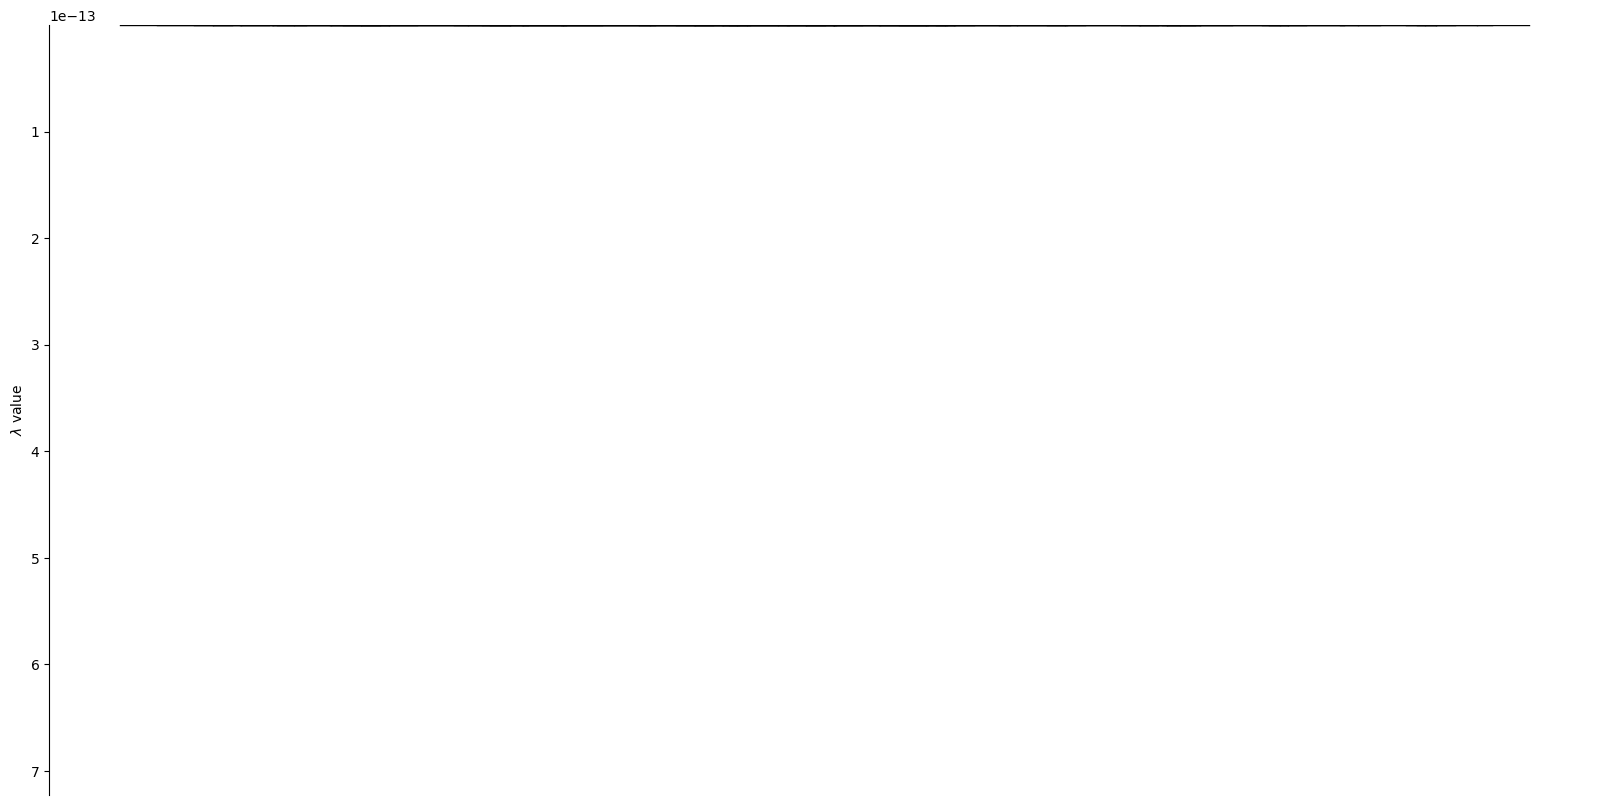

In [97]:
fig,ax = plt.subplots(figsize=(20,10))
CondensedTree(ct_raw).plot(colorbar=False)

In [98]:
# fig, ax = plt.subplots(figsize=(20,10))
# SingleLinkageTree(linkage_tree).plot(axis=ax, truncate_mode='lastp', p=300)

In [99]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
pca_reducer = PCA(n_components=3)
pca_embedding = pca_reducer.fit_transform(component_data)

/tmp/ipykernel_2900642/3759342808.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


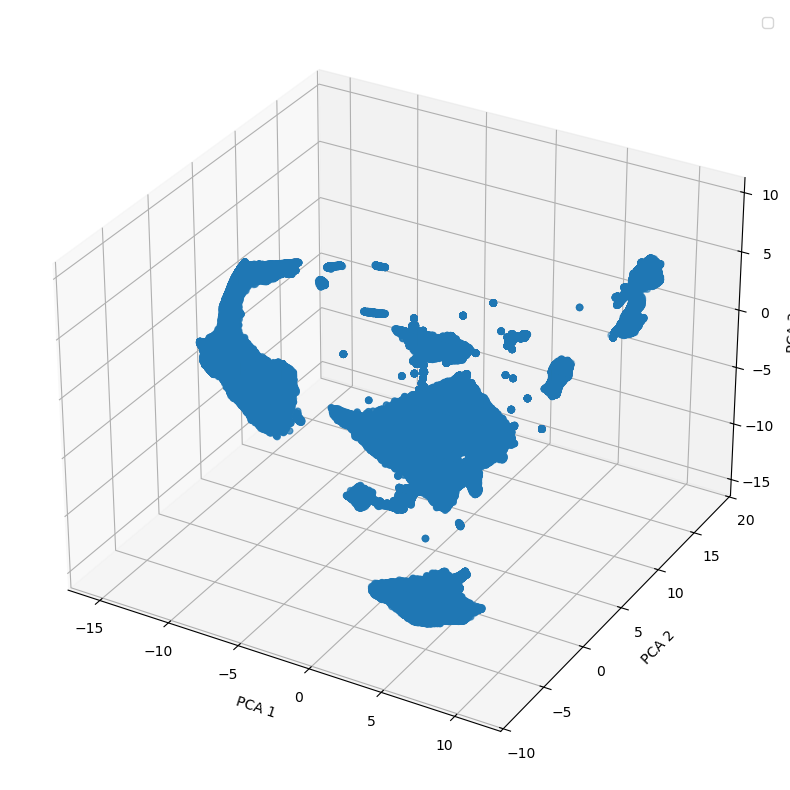

In [100]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(pca_embedding[:, 0], pca_embedding[:, 1], pca_embedding[:, 2])
ax.set_xlabel("PCA 1")
ax.set_ylabel("PCA 2")
ax.set_zlabel("PCA 3")
ax.legend()

NameError: name 'embedding' is not defined

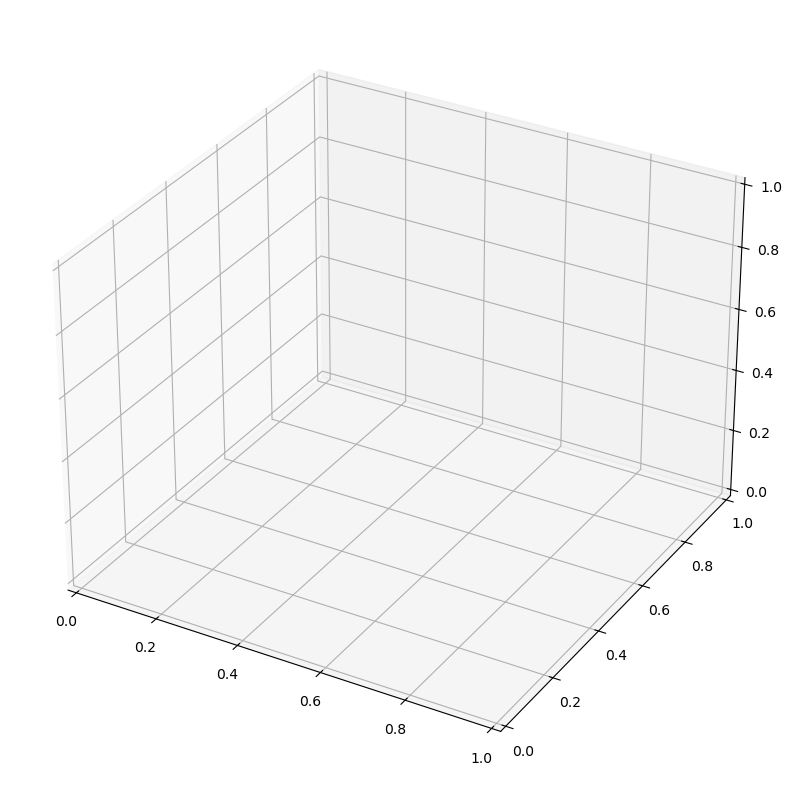

In [101]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(embedding[:, 0], embedding[:, 1], embedding[:, 2])
ax.set_xlabel("UMAP 1")
ax.set_ylabel("UMAP 2")
ax.set_zlabel("UMAP 3")

In [ ]:
# %%time
# n_neighbors = 10
# umap_metric = 'euclidean'

# reducer = umap.UMAP(n_neighbors=10, n_components=2, metric=umap_metric, verbose=True)
# embedding = reducer.fit_transform(component_data.sample(100_000))
import umap.plot
umap.plot.points(reducer)